In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, make_scorer, max_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, ShuffleSplit, cross_validate, train_test_split
from scipy.stats import expon, reciprocal, uniform
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ExpSineSquared, RationalQuadratic
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, chi2, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from mango import Tuner, scheduler
import xgboost as xgb
from skopt  import BayesSearchCV 
import lightgbm as lgb
from sklearn.cluster import OPTICS, MiniBatchKMeans
from pyGRNN import GRNN
from skopt.space import Categorical, Space, Dimension, Integer
from sklearn.inspection import permutation_importance
from optuna.integration import OptunaSearchCV
import optuna
import matplotlib.pyplot as plt
from loading import load_data

In [2]:
numerical_features = ['link_id', 'link_from', 'link_to', 'start_node_x', 'start_node_y', 'end_node_x', 'end_node_y',
                      'link_length', 'link_freespeed', 'link_capacity', 'link_permlanes', 'start_count', 'end_count',
                      'go_to_sum', 'rush_hour', 'max_dur', 'cemdapStopDuration_s', 'length_per_capacity_ratio', 'speed_capacity_ratio',
                      'length_times_lanes', 'speed_times_capacity', 'length_times', 'capacity_divided_by_lanes'
                     ]
category_feature = ['type']
scaler = StandardScaler()
le = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False)
ct = ColumnTransformer(
     [("num_preprocess", scaler, numerical_features),
      ("text_preprocess", ohe, category_feature)], remainder='passthrough').set_output(transform="pandas")
clf = {
    'KNN': KNeighborsClassifier(),
    # 'XGB': xgb.XGBClassifier(random_state=101),
    'LGBM': lgb.LGBMClassifier(random_state=101, verbose=-1),
    'RF': RandomForestClassifier(random_state=101),
    'GB': GradientBoostingClassifier(random_state=101),
    'ANN': MLPClassifier(random_state=101),
    # 'SVR': SVC(),
}

model_space = {
    'KNN': KNeighborsRegressor(),
    # 'XGB': xgb.XGBRegressor(random_state=101),
    'LGBM': lgb.LGBMRegressor(random_state=101, verbose=-1),
    'RF': RandomForestRegressor(random_state=101),
    'GB': GradientBoostingRegressor(random_state=101),
    'ANN': MLPRegressor(random_state=101),
    # 'SVR': SVR(),
}
model_space_feature = {
    'SVR': RandomForestRegressor(random_state=101),
    'KNN': RandomForestRegressor(random_state=101),
    'XGB': xgb.XGBRegressor(random_state=101),
    'LGBM': lgb.LGBMRegressor(random_state=101, verbose=-1),
    'RF': RandomForestRegressor(random_state=101),
    'GB': GradientBoostingRegressor(random_state=101),
    'ANN': RandomForestRegressor(random_state=101),
    # 'GRNN': RandomForestRegressor(random_state=101)
}
param_space = {
'SVR': {
    "C": optuna.distributions.FloatDistribution(1e-5, 1e5, log=True),
    'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto']), 
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),  
    # 'epsilon': optuna.distributions.FloatDistribution(0.01, 1),  
},
'RF':  {
    'max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2']),
    'n_estimators': optuna.distributions.IntDistribution(50, 3001, 50),
    'max_depth': optuna.distributions.IntDistribution(1, 200),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 20),
    # 'criterion': Categorical(['absolute_error', 'friedman_mse'])
},
'GB':{
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 1.0),
    'n_estimators': optuna.distributions.IntDistribution(50, 3001, 50),
    'max_depth': optuna.distributions.IntDistribution(1, 200),
    'min_samples_split': optuna.distributions.IntDistribution(2, 11),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
    'subsample': optuna.distributions.FloatDistribution(0.1, 1.0),
},
'ANN': {
    'hidden_layer_sizes': optuna.distributions.CategoricalDistribution([(100,), (50,), (50, 50), (100, 100), (30, 30, 30)]),
    'activation': optuna.distributions.CategoricalDistribution(['tanh', 'relu', 'identity', 'logistic']),
    'solver': optuna.distributions.CategoricalDistribution(['sgd', 'adam']),
    'alpha': optuna.distributions.FloatDistribution(1e-5, 1e5, log=True),
},
'KNN':{
    'n_neighbors': optuna.distributions.IntDistribution(1, 50),
    'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
    'algorithm': optuna.distributions.CategoricalDistribution(['auto', 'ball_tree', 'kd_tree', 'brute'])
},    
'LGBM': {
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 1.0),
    'n_estimators': optuna.distributions.IntDistribution(50, 3001, 50),
    'max_depth': optuna.distributions.IntDistribution(1, 50),
    'num_leaves': optuna.distributions.IntDistribution(2, 50),
    'min_child_samples': optuna.distributions.IntDistribution(1, 20),
    'subsample': optuna.distributions.FloatDistribution(0.1, 1.0),
    'colsample_bytree': optuna.distributions.FloatDistribution(0.1, 1.0),
},
'XGB': {
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 1.0),
    'n_estimators': optuna.distributions.IntDistribution(50, 3001, 50),
    'max_depth': optuna.distributions.IntDistribution(1, 20),
    'max_leaves': optuna.distributions.IntDistribution(2, 50),
    'max_bin': optuna.distributions.IntDistribution(2, 50),
    'gamma': optuna.distributions.IntDistribution(1, 20),
},
# 'GRNN':{
#     'sigma' : np.arange(0.1, 4, 0.01)
# }
}

In [3]:
train_files = ['s-0.json', 's-1.json', 's-2.json', 's-3.json', 's-4.json','s-5.json', 's-6.json', 's-7.json', 's-8.json', 's-9.json'] 
test_files = ['s-15.json', 's-16.json', 's-17.json', 's-18.json','s-19.json']
validate_files = ['s-10.json', 's-11.json', 's-12.json', 's-13.json','s-14.json']
train_files = ['Data/cutoutWorlds/Train/po-1_pn-1.0_sn-1/' + i for i in train_files]
test_files = ['Data/cutoutWorlds/Test/po-1_pn-1.0_sn-1/' + j for j in test_files]
validate_files = ['Data/cutoutWorlds/Validate/po-1_pn-1.0_sn-1/' + k for k in validate_files]
df_activities = pd.read_pickle("Data/cutoutWorlds/Train/po-1_pn-1.0_sn-1/df_activities.pkl")
df_links_network = pd.read_pickle("Data/cutoutWorlds/Train/po-1_pn-1.0_sn-1/df_links_network.pkl")
train_data = load_data(train_files, df_activities, df_links_network)
validate_data = load_data(validate_files, df_activities, df_links_network)
test_data = load_data(test_files, df_activities, df_links_network)

train_data['dataset'] = 'train'
validate_data['dataset'] = 'validate'
test_data['dataset'] = 'test'
Big_data = pd.concat([train_data, validate_data, test_data], ignore_index=True)
Big_data_tr = ct.fit_transform(Big_data)

In [4]:
cluster = MiniBatchKMeans(n_clusters=5, random_state=101)
Big_data_tr['x_y_coor'] = cluster.fit_predict(Big_data_tr[['num_preprocess__start_node_x', 'num_preprocess__start_node_y',
                                                           'num_preprocess__end_node_x', 'num_preprocess__end_node_y']])
cluster1 = MiniBatchKMeans(n_clusters=100, random_state=101)
Big_data_tr['similar_link'] = cluster1.fit_predict(Big_data_tr[['num_preprocess__link_length', 'num_preprocess__link_freespeed',
                                                           'num_preprocess__link_capacity', 'num_preprocess__link_permlanes']])
cluster2 = MiniBatchKMeans(n_clusters=100, random_state=101)
Big_data_tr['planxml'] = cluster2.fit_predict(Big_data_tr[['num_preprocess__rush_hour', 'num_preprocess__max_dur', 
                                                           'num_preprocess__cemdapStopDuration_s']])
Big_data_tr['used_link'] = 1
Big_data_tr['used_link'][Big_data_tr['remainder__link_counts']==0] = 0

In [5]:
train_data_tr = Big_data_tr[Big_data_tr['remainder__dataset']=='train']
validate_data_tr = Big_data_tr[Big_data_tr['remainder__dataset']=='validate']
test_data_tr = Big_data_tr[Big_data_tr['remainder__dataset']=='test']

train_index = list(train_data_tr.index)
validate_index = list(validate_data_tr.index)

temp = pd.concat([train_data_tr, validate_data_tr], ignore_index=True)
X_t_clf = temp.drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link'])
y_t_clf = temp['used_link']

X_te_clf = test_data_tr.drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link'])
y_te_clf = test_data_tr['used_link']

In [64]:
best_model_clf = {}
for model_name in clf.keys():   
    model = clf[model_name]
    pipeline  = Pipeline([('selector', SelectKBest(f_regression)),
                  ('model', model)])
    param_grid = {}
    param_grid['selector__k']=optuna.distributions.IntDistribution(2, 38)
    for key in param_space[model_name].keys():
        param_grid[f'model__{key}']=param_space[model_name][key]
    
    # BayesSearchCV
    opt = OptunaSearchCV(
        pipeline,
        param_grid,
        n_trials=100,
        cv=[(train_index, validate_index), (train_index, validate_index)]
    )
    opt.fit(X_t_clf, y_t_clf)
    y_pred_clf = opt.predict(X_te_clf)
    best_model_clf[model_name] = [opt, opt.best_score_, y_pred_clf]
    print(model_name, opt.best_score_, accuracy_score(y_te_clf, y_pred_clf))

[I 2024-02-02 21:35:49,288] A new study created in memory with name: no-name-94ffbd76-5e5e-48c8-b656-741771ce8ed3
[I 2024-02-02 21:35:50,429] Trial 0 finished with value: 0.8782854335544092 and parameters: {'selector__k': 14, 'model__n_neighbors': 38, 'model__weights': 'distance', 'model__algorithm': 'kd_tree'}. Best is trial 0 with value: 0.8782854335544092.
[I 2024-02-02 21:35:51,715] Trial 1 finished with value: 0.8513878653893392 and parameters: {'selector__k': 13, 'model__n_neighbors': 38, 'model__weights': 'distance', 'model__algorithm': 'auto'}. Best is trial 0 with value: 0.8782854335544092.
[I 2024-02-02 21:35:52,809] Trial 2 finished with value: 0.6067305330385655 and parameters: {'selector__k': 2, 'model__n_neighbors': 26, 'model__weights': 'distance', 'model__algorithm': 'ball_tree'}. Best is trial 0 with value: 0.8782854335544092.
[I 2024-02-02 21:35:53,581] Trial 3 finished with value: 0.874846475067551 and parameters: {'selector__k': 16, 'model__n_neighbors': 23, 'model_

KNN 0.901744043232621 0.8833484045988891


[I 2024-02-02 21:38:31,706] Trial 0 finished with value: 0.8515106853352985 and parameters: {'selector__k': 8, 'model__learning_rate': 0.0855664181458857, 'model__n_estimators': 101, 'model__max_depth': 46, 'model__num_leaves': 38, 'model__min_child_samples': 1, 'model__subsample': 0.5876611961999043, 'model__colsample_bytree': 0.4319691747146681}. Best is trial 0 with value: 0.8515106853352985.
[I 2024-02-02 21:38:41,003] Trial 1 finished with value: 0.8971997052321297 and parameters: {'selector__k': 38, 'model__learning_rate': 0.40497293477612645, 'model__n_estimators': 1749, 'model__max_depth': 17, 'model__num_leaves': 24, 'model__min_child_samples': 19, 'model__subsample': 0.28832170048744776, 'model__colsample_bytree': 0.9949623902918496}. Best is trial 1 with value: 0.8971997052321297.
[I 2024-02-02 21:38:44,099] Trial 2 finished with value: 0.863301400147384 and parameters: {'selector__k': 27, 'model__learning_rate': 0.012478015666200234, 'model__n_estimators': 1240, 'model__max

LGBM 0.9040776222058462 0.8491151014080868


[I 2024-02-02 21:56:30,868] Trial 0 finished with value: 0.8623188405797102 and parameters: {'selector__k': 18, 'model__max_features': 'sqrt', 'model__n_estimators': 1120, 'model__max_depth': 153, 'model__min_samples_leaf': 18}. Best is trial 0 with value: 0.8623188405797102.
[I 2024-02-02 21:58:24,408] Trial 1 finished with value: 0.8758290346352248 and parameters: {'selector__k': 35, 'model__max_features': 'sqrt', 'model__n_estimators': 1110, 'model__max_depth': 63, 'model__min_samples_leaf': 6}. Best is trial 1 with value: 0.8758290346352248.
[I 2024-02-02 21:58:43,061] Trial 2 finished with value: 0.8715303365266519 and parameters: {'selector__k': 33, 'model__max_features': 'sqrt', 'model__n_estimators': 195, 'model__max_depth': 124, 'model__min_samples_leaf': 13}. Best is trial 1 with value: 0.8758290346352248.
[I 2024-02-02 21:58:53,638] Trial 3 finished with value: 0.8629329403095063 and parameters: {'selector__k': 20, 'model__max_features': 'log2', 'model__n_estimators': 253, '

RF 0.9092360599361337 0.8891616070275158


[I 2024-02-02 23:40:11,679] Trial 0 finished with value: 0.8951117661508229 and parameters: {'selector__k': 38, 'model__learning_rate': 0.5102014834217986, 'model__n_estimators': 164, 'model__max_depth': 120, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__subsample': 0.7547994829740868}. Best is trial 0 with value: 0.8951117661508229.
[I 2024-02-02 23:42:18,341] Trial 1 finished with value: 0.8985507246376812 and parameters: {'selector__k': 32, 'model__learning_rate': 0.9946558317923209, 'model__n_estimators': 752, 'model__max_depth': 51, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__subsample': 0.9904142658344465}. Best is trial 1 with value: 0.8985507246376812.
[I 2024-02-02 23:42:57,439] Trial 2 finished with value: 0.6623679685580939 and parameters: {'selector__k': 28, 'model__learning_rate': 0.48730483727983015, 'model__n_estimators': 198, 'model__max_depth': 159, 'model__min_samples_split': 3, 'model__min_samples_leaf': 3, 'model__subs

GB 0.9084991402603783 0.7373724325022607


[I 2024-02-03 11:55:06,764] Trial 0 finished with value: 0.8324735937116188 and parameters: {'selector__k': 5, 'model__hidden_layer_sizes': (100, 100), 'model__activation': 'tanh', 'model__solver': 'sgd', 'model__alpha': 0.0003608120821092522}. Best is trial 0 with value: 0.8324735937116188.
[I 2024-02-03 11:55:24,951] Trial 1 finished with value: 0.864406779661017 and parameters: {'selector__k': 27, 'model__hidden_layer_sizes': (50,), 'model__activation': 'tanh', 'model__solver': 'adam', 'model__alpha': 1.4060463308001926e-05}. Best is trial 1 with value: 0.864406779661017.
[I 2024-02-03 11:55:36,590] Trial 2 finished with value: 0.8298943748464751 and parameters: {'selector__k': 26, 'model__hidden_layer_sizes': (50, 50), 'model__activation': 'tanh', 'model__solver': 'adam', 'model__alpha': 211.3797258368047}. Best is trial 1 with value: 0.864406779661017.
[I 2024-02-03 11:56:46,399] Trial 3 finished with value: 0.8481945467943994 and parameters: {'selector__k': 34, 'model__hidden_lay

ANN 0.8742323753377549 0.8060974034362486


ValueError: Invalid parameter 'epsilon' for estimator SVC(C=0.5581004357734431). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [65]:
import pickle
with open('best_model_clf.pickle', 'wb') as f:
    pickle.dump(best_model_clf, f, pickle.HIGHEST_PROTOCOL)

In [6]:
best_model_clf = pd.read_pickle("best_model_clf.pickle")

In [8]:
best_md_from_clf = sorted(best_model_clf.items(), key=lambda t: t[1][1])[-1]
temp_tr = test_data_tr.copy(deep=True)
temp_tr['y_pred_clf'] = best_md_from_clf[1][2]

In [9]:
temp_tr

num_preprocess__link_id  num_preprocess__link_from  \
25127                -1.693699                  -0.690729   
25128                -1.691653                   1.344364   
25129                -1.689608                   1.725646   
25130                -1.687562                   1.630325   
25131                -1.685517                  -1.491421   
...                        ...                        ...   
32863                 1.354235                  -0.080678   
32864                 1.356281                   1.577899   
32865                 1.358326                   1.577899   
32866                 1.360372                  -0.719325   
32867                 1.362418                  -0.080678   

       num_preprocess__link_to  num_preprocess__start_node_x  \
25127                -0.321831                     -0.127082   
25128                -0.369501                     -0.162070   
25129                 1.632640                     -0.176623   
25130                 1.727980                     -0.177806   
25131                -0.827133                     -0.209981   
...                        ...                           ...   
32863                 1.580203                      2.354492   
32864                -0.078714                      2.355207   
32865                -0.717492                      2.355207   
32866                 1.580203                      2.356967   
32867                -0.641220                      2.354492   

       num_preprocess__start_node_y  num_preprocess__end_node_x  \
25127                      0.169554                   -0.117496   
25128                      0.181103                   -0.165816   
25129                      0.215705                   -0.177808   
25130                      0.212347                   -0.176625   
25131                      0.207215                   -0.212395   
...                             ...                         ...   
32863                     -3.257553                    2.355202   
32864                     -3.257816                    2.354487   
32865                     -3.257816                    2.356962   
32866                     -3.258785                    2.355202   
32867                     -3.257553                    2.353854   

       num_preprocess__end_node_y  num_preprocess__link_length  \
25127                    0.168076                     0.161369   
25128                    0.181080                    -0.265100   
25129                    0.212357                    -0.248782   
25130                    0.215715                    -0.248782   
25131                    0.207159                    -0.357929   
...                           ...                          ...   
32863                   -3.257839                    -0.475882   
32864                   -3.257575                    -0.475882   
32865                   -3.258808                    -0.384487   
32866                   -3.257839                    -0.384487   
32867                   -3.257836                    -0.480536   

       num_preprocess__link_freespeed  num_preprocess__link_capacity  ...  \
25127                       -0.017958                      -0.523908  ...   
25128                       -0.017958                       1.443606  ...   
25129                       -0.017958                      -0.069866  ...   
25130                       -0.017958                      -0.069866  ...   
25131                       -0.017958                       3.865162  ...   
...                               ...                            ...  ...   
32863                       -0.017958                       0.232829  ...   
32864                       -0.017958                       0.232829  ...   
32865                       -0.017958                       0.232829  ...   
32866                       -0.017958                       0.232829  ...   
32867                       -0.017958                      -

In [10]:
used_link_1 = temp[temp['used_link']==1]
used_link_1_train = used_link_1[used_link_1['remainder__dataset']=='train']
used_link_1_validate = used_link_1[used_link_1['remainder__dataset']=='validate']
temp_2 = pd.concat([used_link_1_train, used_link_1_validate], ignore_index=True)
X_t = temp_2.drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link'])
y_t = temp_2['remainder__link_counts']

train_index = list(temp_2[temp_2['remainder__dataset']=='train'].index)
validate_index = list(temp_2[temp_2['remainder__dataset']=='validate'].index)

X_te = temp_tr[temp_tr['y_pred_clf']==1].drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link', 'y_pred_clf'])
y_te = temp_tr[temp_tr['y_pred_clf']==1]['remainder__link_counts']

X_te_0 = temp_tr[temp_tr['y_pred_clf']==0].drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link', 'y_pred_clf'])
X_te_0['y_pred'] = 0
y_te_0 = temp_tr[temp_tr['y_pred_clf']==0]['remainder__link_counts']
y_te_all = pd.concat([y_te, y_te_0])

In [11]:
best_model_reg = {}
for model_name in model_space.keys():   
    model = model_space[model_name]
    pipeline  = Pipeline([('selector', SelectKBest(f_regression)),
                  ('model', model)])
    param_grid = {}
    param_grid['selector__k']=optuna.distributions.IntDistribution(2, 38)
    for key in param_space[model_name].keys():
        param_grid[f'model__{key}']=param_space[model_name][key]
    
    # BayesSearchCV
    opt = OptunaSearchCV(
        pipeline,
        param_grid,
        n_trials=50,
        cv=[(train_index, validate_index), (train_index, validate_index)],
        scoring='neg_mean_absolute_error'
    )
    opt.fit(X_t, y_t)
    y_pred = opt.predict(X_te)
    y_pred_all = np.concatenate([y_pred, np.array(X_te_0['y_pred'])])
    mae = mean_absolute_error(y_te_all, y_pred_all)
    mse = mean_squared_error(y_te_all, y_pred_all)
    me = max_error(y_te_all, y_pred_all)
    best_model_reg[model_name] = (opt, mae, mse, me)
    print(model_name, opt.best_score_, mae, mse, me)

[I 2024-02-05 19:20:42,506] A new study created in memory with name: no-name-7fea6117-38d1-4080-8386-2d856f183c6c
[I 2024-02-05 19:20:43,014] Trial 0 finished with value: -15.006034323127174 and parameters: {'selector__k': 10, 'model__n_neighbors': 4, 'model__weights': 'distance', 'model__algorithm': 'kd_tree'}. Best is trial 0 with value: -15.006034323127174.
[I 2024-02-05 19:20:45,071] Trial 1 finished with value: -16.480122651636332 and parameters: {'selector__k': 35, 'model__n_neighbors': 31, 'model__weights': 'distance', 'model__algorithm': 'ball_tree'}. Best is trial 0 with value: -15.006034323127174.
[I 2024-02-05 19:20:45,685] Trial 2 finished with value: -14.84901941804485 and parameters: {'selector__k': 28, 'model__n_neighbors': 32, 'model__weights': 'distance', 'model__algorithm': 'auto'}. Best is trial 2 with value: -14.84901941804485.
[I 2024-02-05 19:20:49,383] Trial 3 finished with value: -15.36721574778698 and parameters: {'selector__k': 19, 'model__n_neighbors': 5, 'mo

KNN -12.221872718471136 12.736465566854655 514.6499271249987 200.8763726900807


[I 2024-02-05 19:21:34,106] Trial 0 finished with value: -16.965311728577735 and parameters: {'selector__k': 36, 'model__learning_rate': 0.15069482882033144, 'model__n_estimators': 92, 'model__max_depth': 10, 'model__num_leaves': 17, 'model__min_child_samples': 18, 'model__subsample': 0.3595828922684381, 'model__colsample_bytree': 0.4713327557246473}. Best is trial 0 with value: -16.965311728577735.
[I 2024-02-05 19:21:35,320] Trial 1 finished with value: -15.587552369144982 and parameters: {'selector__k': 34, 'model__learning_rate': 0.5945024966350402, 'model__n_estimators': 301, 'model__max_depth': 18, 'model__num_leaves': 23, 'model__min_child_samples': 9, 'model__subsample': 0.1534896524109178, 'model__colsample_bytree': 0.2133704906700291}. Best is trial 1 with value: -15.587552369144982.
[I 2024-02-05 19:21:35,805] Trial 2 finished with value: -14.068659066603749 and parameters: {'selector__k': 17, 'model__learning_rate': 0.46394817505910324, 'model__n_estimators': 131, 'model__m

LGBM -13.175633704628108 13.647032093691852 517.5001671128582 192.31165747050488


[I 2024-02-05 19:22:54,166] Trial 0 finished with value: -15.880089253816909 and parameters: {'selector__k': 23, 'model__max_features': 'log2', 'model__n_estimators': 258, 'model__max_depth': 118, 'model__min_samples_leaf': 8}. Best is trial 0 with value: -15.880089253816909.
[I 2024-02-05 19:23:44,736] Trial 1 finished with value: -15.60816326105218 and parameters: {'selector__k': 29, 'model__max_features': 'log2', 'model__n_estimators': 355, 'model__max_depth': 148, 'model__min_samples_leaf': 1}. Best is trial 1 with value: -15.60816326105218.
[I 2024-02-05 19:25:14,370] Trial 2 finished with value: -16.152655611925262 and parameters: {'selector__k': 31, 'model__max_features': 'sqrt', 'model__n_estimators': 863, 'model__max_depth': 77, 'model__min_samples_leaf': 4}. Best is trial 1 with value: -15.60816326105218.
[I 2024-02-05 19:25:15,205] Trial 3 finished with value: -13.668481067206413 and parameters: {'selector__k': 10, 'model__max_features': 'log2', 'model__n_estimators': 69, 'm

RF -12.872261106804938 13.02691345098152 505.7710415735744 223.73239436619718


[I 2024-02-05 19:39:37,272] Trial 0 finished with value: -14.395374733107646 and parameters: {'selector__k': 3, 'model__learning_rate': 0.3919067211214676, 'model__n_estimators': 688, 'model__max_depth': 81, 'model__min_samples_split': 4, 'model__min_samples_leaf': 6, 'model__subsample': 0.7162800155494966}. Best is trial 0 with value: -14.395374733107646.
[I 2024-02-05 19:39:41,001] Trial 1 finished with value: -13.758643225819416 and parameters: {'selector__k': 9, 'model__learning_rate': 0.30083774014849035, 'model__n_estimators': 72, 'model__max_depth': 52, 'model__min_samples_split': 5, 'model__min_samples_leaf': 3, 'model__subsample': 0.9456801433725278}. Best is trial 1 with value: -13.758643225819416.
[I 2024-02-05 20:06:16,949] Trial 2 finished with value: -15.82739412318822 and parameters: {'selector__k': 33, 'model__learning_rate': 0.02461374766057477, 'model__n_estimators': 1784, 'model__max_depth': 17, 'model__min_samples_split': 4, 'model__min_samples_leaf': 3, 'model__sub

GB -12.8132996683797 13.48214256945878 566.2499018749647 218.81072355120784


[I 2024-02-05 23:17:24,252] Trial 0 finished with value: -24.336939632997137 and parameters: {'selector__k': 25, 'model__hidden_layer_sizes': (30, 30, 30), 'model__activation': 'tanh', 'model__solver': 'sgd', 'model__alpha': 0.0030164737453342717}. Best is trial 0 with value: -24.336939632997137.
[I 2024-02-05 23:17:58,990] Trial 1 finished with value: -71.80476942283875 and parameters: {'selector__k': 27, 'model__hidden_layer_sizes': (100, 100), 'model__activation': 'relu', 'model__solver': 'adam', 'model__alpha': 30.309556591864887}. Best is trial 0 with value: -24.336939632997137.
[I 2024-02-05 23:18:35,119] Trial 2 finished with value: -13.412907670976596 and parameters: {'selector__k': 14, 'model__hidden_layer_sizes': (30, 30, 30), 'model__activation': 'logistic', 'model__solver': 'adam', 'model__alpha': 0.02799592709856076}. Best is trial 2 with value: -13.412907670976596.
[W 2024-02-05 23:18:51,777] Trial 3 failed with parameters: {'selector__k': 33, 'model__hidden_layer_sizes':

ANN -13.126980435447473 13.291405077024832 523.6970377843539 198.72834744438833


In [79]:
X_t_onlyreg = temp.drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link'])
y_t_onlyreg = temp['remainder__link_counts']

X_te_onlyreg = test_data_tr.drop(columns=['remainder__dataset', 'remainder__link_counts', 'used_link'])
y_te_onlyreg = test_data_tr['remainder__link_counts']

train_index_onlyreg = list(train_data_tr.index)
validate_index_onlyreg = list(validate_data_tr.index)

In [ ]:
best_model_onlyreg = {}
for model_name in model_space.keys():   
    model = model_space[model_name]
    pipeline  = Pipeline([('selector', SelectKBest(f_regression)),
                  ('model', model)])
    param_grid = {}
    param_grid['selector__k']=optuna.distributions.IntDistribution(2, 38)
    for key in param_space[model_name].keys():
        param_grid[f'model__{key}']=param_space[model_name][key]
    
    # BayesSearchCV
    opt = OptunaSearchCV(
        pipeline,
        param_grid,
        n_trials=50,
        cv=[(train_index_onlyreg, validate_index_onlyreg), (train_index_onlyreg, validate_index_onlyreg)],
        scoring='neg_mean_absolute_error'
    )
    opt.fit(X_t_onlyreg, y_t_onlyreg)
    y_pred = opt.predict(X_te_onlyreg)
    mae = mean_absolute_error(y_te_onlyreg, y_pred)
    mse = mean_squared_error(y_te_onlyreg, y_pred)
    me = max_error(y_te_onlyreg, y_pred)
    best_model_onlyreg[model_name] = [opt, mae, mse, me]
    print(model_name, opt.best_score_, mae, mse, me)



[I 2024-02-05 10:53:01,862] A new study created in memory with name: no-name-f0321136-70f4-4138-bbe7-4d3ecbb539ba
[I 2024-02-05 10:53:04,248] Trial 0 finished with value: -12.390149840334072 and parameters: {'selector__k': 10, 'model__n_neighbors': 25, 'model__weights': 'uniform', 'model__algorithm': 'ball_tree'}. Best is trial 0 with value: -12.390149840334072.
[I 2024-02-05 10:53:05,206] Trial 1 finished with value: -15.64356287016567 and parameters: {'selector__k': 38, 'model__n_neighbors': 27, 'model__weights': 'uniform', 'model__algorithm': 'brute'}. Best is trial 0 with value: -12.390149840334072.
[I 2024-02-05 10:53:05,985] Trial 2 finished with value: -11.955689292830044 and parameters: {'selector__k': 12, 'model__n_neighbors': 9, 'model__weights': 'uniform', 'model__algorithm': 'kd_tree'}. Best is trial 2 with value: -11.955689292830044.
[I 2024-02-05 10:53:10,181] Trial 3 finished with value: -12.946610921450379 and parameters: {'selector__k': 14, 'model__n_neighbors': 49, 'm

KNN -10.74924426433106 13.927662674366662 623.0457300852435 217.6727743973743


[I 2024-02-05 10:54:19,198] Trial 0 finished with value: -11.553049210759953 and parameters: {'selector__k': 19, 'model__learning_rate': 0.13780654147504143, 'model__n_estimators': 205, 'model__max_depth': 33, 'model__num_leaves': 44, 'model__min_child_samples': 20, 'model__subsample': 0.758979329155287, 'model__colsample_bytree': 0.8535808316142959}. Best is trial 0 with value: -11.553049210759953.
[I 2024-02-05 10:54:19,649] Trial 1 finished with value: -15.33540948520767 and parameters: {'selector__k': 33, 'model__learning_rate': 0.5805571524428217, 'model__n_estimators': 104, 'model__max_depth': 34, 'model__num_leaves': 4, 'model__min_child_samples': 8, 'model__subsample': 0.12089316243031409, 'model__colsample_bytree': 0.2681793292493914}. Best is trial 0 with value: -11.553049210759953.
[I 2024-02-05 10:54:24,564] Trial 2 finished with value: -15.491737280292638 and parameters: {'selector__k': 33, 'model__learning_rate': 0.8390474709369399, 'model__n_estimators': 1913, 'model__ma

LGBM -11.500926154129049 13.061599632669417 496.68882396915853 224.45425665456546


[I 2024-02-05 10:56:28,088] Trial 0 finished with value: -12.919956381981017 and parameters: {'selector__k': 5, 'model__max_features': 'sqrt', 'model__n_estimators': 705, 'model__max_depth': 64, 'model__min_samples_leaf': 2}. Best is trial 0 with value: -12.919956381981017.
[I 2024-02-05 10:57:08,091] Trial 1 finished with value: -14.33180615379754 and parameters: {'selector__k': 29, 'model__max_features': 'log2', 'model__n_estimators': 621, 'model__max_depth': 79, 'model__min_samples_leaf': 18}. Best is trial 0 with value: -12.919956381981017.
[I 2024-02-05 10:57:14,049] Trial 2 finished with value: -14.586095539564427 and parameters: {'selector__k': 35, 'model__max_features': 'log2', 'model__n_estimators': 65, 'model__max_depth': 31, 'model__min_samples_leaf': 18}. Best is trial 0 with value: -12.919956381981017.
[I 2024-02-05 10:57:54,242] Trial 3 finished with value: -11.628871184086464 and parameters: {'selector__k': 17, 'model__max_features': 'log2', 'model__n_estimators': 644, '

RF -11.317254531246734 12.956446158582265 489.3172155249802 210.46575684539013


[I 2024-02-05 11:23:22,419] Trial 0 finished with value: -18.524331312528922 and parameters: {'selector__k': 34, 'model__learning_rate': 0.32532782686486555, 'model__n_estimators': 108, 'model__max_depth': 70, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__subsample': 0.22072162464408046}. Best is trial 0 with value: -18.524331312528922.
[I 2024-02-05 11:52:37,222] Trial 1 finished with value: -15.985176266810951 and parameters: {'selector__k': 29, 'model__learning_rate': 0.430341139419359, 'model__n_estimators': 832, 'model__max_depth': 70, 'model__min_samples_split': 7, 'model__min_samples_leaf': 10, 'model__subsample': 0.6448815332186794}. Best is trial 1 with value: -15.985176266810951.
[I 2024-02-05 11:53:10,602] Trial 2 finished with value: -12.410181669426867 and parameters: {'selector__k': 6, 'model__learning_rate': 0.0450679794892195, 'model__n_estimators': 1841, 'model__max_depth': 39, 'model__min_samples_split': 9, 'model__min_samples_leaf': 9, 'model__

GB -11.066119298228337 13.285416147020538 514.7948155699444 223.36467640687823


[W 2024-02-05 14:12:59,211] Trial 0 failed with parameters: {'selector__k': 11, 'model__hidden_layer_sizes': (100, 100), 'model__activation': 'identity', 'model__solver': 'sgd', 'model__alpha': 282.6633053943985} because of the following error: The value nan is not acceptable.
[W 2024-02-05 14:12:59,212] Trial 0 failed with value nan.
[I 2024-02-05 14:13:11,004] Trial 1 finished with value: -14.214426474247963 and parameters: {'selector__k': 18, 'model__hidden_layer_sizes': (100,), 'model__activation': 'identity', 'model__solver': 'adam', 'model__alpha': 0.028449926308425473}. Best is trial 1 with value: -14.214426474247963.
[I 2024-02-05 14:13:26,732] Trial 2 finished with value: -15.386979191297016 and parameters: {'selector__k': 12, 'model__hidden_layer_sizes': (100, 100), 'model__activation': 'tanh', 'model__solver': 'sgd', 'model__alpha': 830.0305342597891}. Best is trial 1 with value: -14.214426474247963.
[I 2024-02-05 14:13:38,653] Trial 3 finished with value: -17.05618526479737

ANN -11.463056175593943 13.483643547975962 542.7660320233928 230.89096658411296


[I 2024-02-05 14:33:40,930] Trial 0 finished with value: -14.194694580834426 and parameters: {'selector__k': 10, 'model__C': 60.66417663943302, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__epsilon': 0.8470607437299689}. Best is trial 0 with value: -14.194694580834426.
[I 2024-02-05 14:34:03,829] Trial 1 finished with value: -14.912414579612541 and parameters: {'selector__k': 8, 'model__C': 0.5308191002543827, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__epsilon': 0.22025564162463604}. Best is trial 0 with value: -14.194694580834426.
[I 2024-02-05 14:34:44,302] Trial 2 finished with value: -13.837529994718384 and parameters: {'selector__k': 6, 'model__C': 27.890001762505236, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'model__epsilon': 0.800671062087597}. Best is trial 2 with value: -13.837529994718384.
[I 2024-02-05 14:35:32,656] Trial 3 finished with value: -7099.739502502318 and parameters: {'selector__k': 36, 'model__C': 24.54274123762528, 'model__

In [ ]:
with open('best_model_onlyreg.pickle', 'wb') as f:
    pickle.dump(best_model_onlyreg, f, pickle.HIGHEST_PROTOCOL)

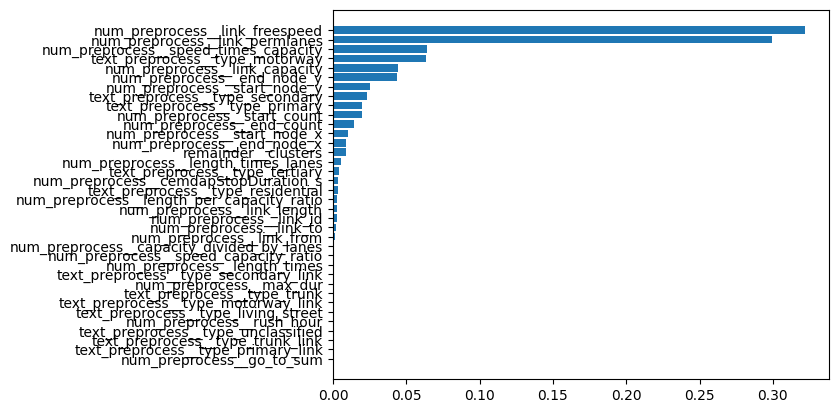

In [299]:

# X_t = X_t_old[selected_features] 
# X_t['cluster'] = train_data_tr['remainder__clusters']
# X_t['remainder__link_counts'] = train_data_tr['remainder__link_counts']
# X_v = validate_data_tr[selected_features]
# X_v['cluster'] = validate_data_tr['remainder__clusters']
# X_v['remainder__link_counts'] = validate_data_tr['remainder__link_counts']
# X_te = test_data_tr[selected_features]
# X_te['cluster'] = test_data_tr['remainder__clusters']
# X_te['remainder__link_counts'] = test_data_tr['remainder__link_counts']

In [301]:
selected_features

Index(['num_preprocess__link_freespeed', 'num_preprocess__link_permlanes'], dtype='object')

In [ ]:
model = xgb.XGBRegressor(random_state=101)
opt = BayesSearchCV(
    model,
    param_space['XGB'],
    n_iter=50,  # Adjust the number of iterations based on your computational resources
    cv=ShuffleSplit(test_size=0.20, n_splits=3),  # Adjust the number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use a suitable regression metric
    n_jobs=-1,
)

opt.fit(X_t, y_t)
best_params = opt.best_params_ 

model = xgb.XGBRegressor(**best_params, random_state=101)
model.fit(X_t, y_t)
te_predictions = model.predict(X_te)
te_mae = mean_absolute_error(y_te, te_predictions)
print(te_mae)

onehot = OneHotEncoder()
X_t_leaves = onehot.fit_transform(model.apply(X_t))
rf_lr = LogisticRegressionCV(cv=ShuffleSplit(test_size=0.20, n_splits=3))
rf_lr.fit(X_t_leaves, y_t)
X_te_leaves = onehot.transform(model.apply(X_te))
y_te_pred_rf_lr = rf_lr.predict(X_te_leaves)
te_rflr_mae = mean_absolute_error(y_te, y_te_pred_rf_lr)
print(te_rflr_mae)

14.492225946967045


In [277]:
v_mae_list = []
te_mae_list = []
v_rf_mae_list = []
te_rf_mae_list = []
# X_te['cluster'] = 1
for cluster_label in list(set(X_t['cluster'])):
    X_v_cluster, X_te_cluster = None, None
    v_mae, te_mae, v_rflr_mae, te_rflr_mae = None, None, None, None
    # Subset the training data for the current cluster
    X_t_cluster = X_t[X_t['cluster'] == cluster_label]
    y_t_cluster = X_t_cluster['remainder__link_counts']
    X_t_cluster = X_t_cluster.drop(columns=['remainder__link_counts','cluster'])  
    
    if cluster_label in list(set(X_v['cluster'])):
        X_v_cluster = X_v[X_v['cluster'] == cluster_label]
        y_v_cluster = X_v_cluster['remainder__link_counts']
        X_v_cluster = X_v_cluster.drop(columns=['remainder__link_counts','cluster'])  
    if cluster_label in list(set(X_te['cluster'])):
        X_te_cluster = X_te[X_te['cluster'] == cluster_label]
        y_te_cluster = X_te_cluster['remainder__link_counts']
        X_te_cluster = X_te_cluster.drop(columns=['remainder__link_counts','cluster'])  
    

    # Train a regression model for the current cluster
    # model = RidgeCV(scoring='neg_mean_absolute_error')
    # model = RandomForestRegressor(criterion='friedman_mse', n_estimators=300,
    #                   random_state=101)

    if not ((X_v_cluster is None) and (X_te_cluster is None)):

        model = xgb.XGBRegressor(random_state=101)
        opt = BayesSearchCV(
            model,
            param_space['XGB'],
            n_iter=60,  # Adjust the number of iterations based on your computational resources
            cv=ShuffleSplit(test_size=0.20, n_splits=1),  # Adjust the number of cross-validation folds
            scoring='neg_mean_absolute_error',  # Use a suitable regression metric
            n_jobs=-1,
        )
        
        opt.fit(X_t_cluster, y_t_cluster)
        best_params = opt.best_params_ 
        onehot = OneHotEncoder()
        model = xgb.XGBRegressor(**best_params, random_state=101)
        model.fit(X_t_cluster, y_t_cluster)

        X_t_leaves = onehot.fit_transform(model.apply(X_t_cluster))
        rf_lr = LogisticRegression()
        rf_lr.fit(X_t_leaves, y_t_cluster)
        if (X_v_cluster is not None):
            v_predictions = model.predict(X_v_cluster)
            v_mae = mean_absolute_error(y_v_cluster, v_predictions)
            row_count = len(y_v_cluster)
            v_mae_list.append(v_mae*row_count)

            X_v_leaves = onehot.transform(model.apply(X_v_cluster))
            y_v_pred_rf_lr = rf_lr.predict(X_v_leaves)
            row_count = len(y_v_pred_rf_lr)
            v_rflr_mae = mean_absolute_error(y_v_cluster, y_v_pred_rf_lr)
            v_rf_mae_list.append(v_rflr_mae*row_count)
        if (X_te_cluster is not None):
            te_predictions = model.predict(X_te_cluster)
            te_mae = mean_absolute_error(y_te_cluster, te_predictions)
            row_count = len(y_te_cluster)
            te_mae_list.append(te_mae*row_count)
      
            X_te_leaves = onehot.transform(model.apply(X_te_cluster))
            y_te_pred_rf_lr = rf_lr.predict(X_te_leaves)
            row_count = len(y_te_pred_rf_lr)
            te_rflr_mae = mean_absolute_error(y_te_cluster, y_te_pred_rf_lr)
            te_rf_mae_list.append(te_rflr_mae*row_count)
    print(cluster_label, v_mae, te_mae, v_rflr_mae, te_rflr_mae)
v_mae_list = list(filter(lambda item: item is not None, v_mae_list))    
te_mae_list = list(filter(lambda item: item is not None, te_mae_list))    
v_mean_mae = sum(v_mae_list)/len(X_v)
te_mean_mae = sum(te_mae_list)/len(X_te)
print(v_mean_mae)
print(te_mean_mae)    

0 None 38.370742752707216 None 38.40828402366864
1 None None None None
2 None None None None
3 None None None None
4 None 24.140446585196035 None 31.296296296296298
5 None None None None
6 None None None None
7 23.32067610409563 23.766770244852335 22.70086705202312 23.03256150506512
8 None 15.213619280465041 None 15.354430379746836
9 None 17.027469520383388 None 19.753597122302157
23.32067610409563
21.802472826700722


In [73]:
best_params = None
best_mae = 0.0

# Generate all combinations of hyperparameters
param_combinations = product(*param_grid.values())
# Loop through hyperparameter combinations
for params in param_combinations:
    # Create and train the model with the current hyperparameters
    model = lgb.LGBMRegressor(**dict(zip(param_grid.keys(), params)), random_state=101)
    model.fit(X_t[X_v.columns], y_t)

    # Evaluate the model on the validation dataset
    y_val_pred = model.predict(X_v)
    mae = mean_absolute_error(y_v, y_val_pred)

    # Check if current hyperparameters are the best
    if mae > best_mae:
        best_mae = mae
        best_params = dict(zip(param_grid.keys(), params))
print(best_mae)
print(best_params)
# Train the final model using the entire training dataset with the best hyperparameters
final_model = lgb.LGBMRegressor(**best_params, random_state=101)
final_model.fit(X_t, y_t)

# Evaluate the final model on the test dataset
y_test_pred = final_model.predict(X_te)
test_mae = mean_absolute_error(y_te, y_test_pred)
print(test_mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 16985, number of used features: 17
[LightGBM] [Info] Start training from score 18.544951


ValueError: Found input variables with inconsistent numbers of samples: [1724, 8142]

In [ ]:
# Define the LGBMRegressor model
lgbm_model = lgb.LGBMRegressor(random_state=101, force_col_wise=True)

# Create a Bayesian optimization object
opt = BayesSearchCV(
    lgbm_model,
    param_space,
    n_iter=100,  # Adjust the number of iterations based on your computational resources
    cv=3,  # Adjust the number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use a suitable regression metric
    n_jobs=-1,
)

# Perform Bayesian optimization
opt.fit(X_t[X_v.columns], y_t, eval_set = [(X_v, y_v)])

# Get the best hyperparameters
best_params = opt.best_params_
print(opt.best_estimator_)

# Train the final model with the best hyperparameters
final_model = lgb.LGBMRegressor(**best_params, random_state=101, force_col_wise=True)
final_model.fit(X_t, y_t, eval_set = [(X_te, y_te)])

print("With LGB Pred")
y_t_pred = final_model.predict(X_t)
print(mean_absolute_error(y_t, y_t_pred))

y_te_pred = final_model.predict(X_te)
print(mean_absolute_error(y_te, y_te_pred))


In [ ]:
print("---------------")

onehot = OneHotEncoder()
X_t_leaves = onehot.fit_transform(final_model.predict(X_t, pred_leaf=True))
xgb_lr = LogisticRegression()
xgb_lr.fit(X_t_leaves, y_t)

print("With LGB + LR Pred")
X_t_leaves = onehot.transform(final_model.predict(X_t, pred_leaf=True))
y_t_pred_xgb_lr = xgb_lr.predict(X_t_leaves)
print(mean_absolute_error(y_t, y_t_pred_xgb_lr))

X_te_leaves = onehot.transform(final_model.predict(X_te, pred_leaf=True))
y_te_pred_xgb_lr = xgb_lr.predict(X_te_leaves)
print(mean_absolute_error(y_te, y_te_pred_xgb_lr))

In [ ]:
param_space = {
    'learning_rate': np.arange(0.01, 1.0, 0.01),
    'n_estimators': np.arange(50, 2001, 50),
    'max_depth': np.arange(1, 20),
    'max_leaves': np.arange(2, 50),
    'max_bin': np.arange(2, 50),
    'gamma': np.arange(1, 20),
    # 'min_child_weight': np.arange(0, 20),
    # 'subsample': np.arange(0.1, 1.0, 0.1),
    # 'colsample_bytree': np.arange(0.1, 1.0, 0.1),
    # 'reg_alpha': np.arange(0, 100),
    # 'reg_lambda': np.arange(0, 10, 0.01),
}

# Define the LGBMRegressor model
xgb_model = xgb.XGBRegressor(random_state=101)

# Create a Bayesian optimization object
opt = BayesSearchCV(
    xgb_model,
    param_space,
    n_iter=100,  # Adjust the number of iterations based on your computational resources
    cv=3,  # Adjust the number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use a suitable regression metric
    n_jobs=-1,
)

# Perform Bayesian optimization
opt.fit(X_t[X_v.columns], y_t, eval_set = [(X_v, y_v)])
# 
# Get the best hyperparameters
best_params = opt.best_params_
print(opt.best_estimator_)

# Train the final model using the entire training dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params, random_state=101)
final_model.fit(X_t, y_t, eval_set = [(X_te, y_te)])

# Evaluate the final model on the test dataset
y_test_pred = final_model.predict(X_te)
test_mae = mean_absolute_error(y_te, y_test_pred)
print(test_mae)

In [ ]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params, random_state=101)
final_model.fit(X_t, y_t)

print("With XGB Pred")
y_t_pred = final_model.predict(X_t)
print(mean_absolute_error(y_t, y_t_pred))

y_te_pred = final_model.predict(X_te)
print(mean_absolute_error(y_te, y_te_pred))

print("---------------")

onehot = OneHotEncoder()
X_t_leaves = onehot.fit_transform(final_model.apply(X_t))
xgb_lr = LogisticRegression()
xgb_lr.fit(X_t_leaves, y_t)

print("With XGB + LR Pred")
X_t_leaves = onehot.transform(final_model.apply(X_t))
y_t_pred_xgb_lr = xgb_lr.predict(X_t_leaves)
print(mean_absolute_error(y_t, y_t_pred_xgb_lr))

X_te_leaves = onehot.transform(final_model.apply(X_te))
y_te_pred_xgb_lr = xgb_lr.predict(X_te_leaves)
print(mean_absolute_error(y_te, y_te_pred_xgb_lr))


# # Make predictions on the validation set
# y_pred = final_model.predict(X_te)

# # Evaluate the model on the validation set
# mae = mean_absolute_error(y_te, y_pred)
# print(f'Mean Absolute Error on Validation Set: {mae}')

In [ ]:
param_space =  {
    'max_features': Categorical(['sqrt', 'log2']),
    'n_estimators': np.arange(50, 2001, 50),
    'bootstrap': Categorical([True, False]),
    'max_depth': np.arange(1, 20),
    'min_samples_leaf': np.arange(1, 20),
    'criterion': Categorical(['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
}
# Define the LGBMRegressor model
rf_model = RandomForestRegressor(random_state=101)

# Create a Bayesian optimization object
opt = BayesSearchCV(
    rf_model,
    param_space,
    n_iter=100,  # Adjust the number of iterations based on your computational resources
    cv=3,  # Adjust the number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use a suitable regression metric
    n_jobs=-1,
)

# Perform Bayesian optimization
opt.fit(X_t, y_t)

# Get the best hyperparameters
best_params = opt.best_params_
print(opt.best_estimator_)


In [ ]:
# Train the final model with the best hyperparameters
final_model = RandomForestRegressor(**best_params, random_state=101)
final_model.fit(X_t, y_t)

print("With RF Pred")
y_t_pred = final_model.predict(X_t)
print(mean_absolute_error(y_t, y_t_pred))

y_te_pred = final_model.predict(X_te)
print(mean_absolute_error(y_te, y_te_pred))

print("---------------")

onehot = OneHotEncoder()
X_t_leaves = onehot.fit_transform(final_model.apply(X_t))
xgb_lr = LogisticRegression()
xgb_lr.fit(X_t_leaves, y_t)

print("With XGB + LR Pred")
X_t_leaves = onehot.transform(final_model.apply(X_t))
y_t_pred_xgb_lr = xgb_lr.predict(X_t_leaves)
print(mean_absolute_error(y_t, y_t_pred_xgb_lr))

X_te_leaves = onehot.transform(final_model.apply(X_te))
y_te_pred_xgb_lr = xgb_lr.predict(X_te_leaves)
print(mean_absolute_error(y_te, y_te_pred_xgb_lr))

In [ ]:
param_space = {
    'learning_rate': np.arange(0.01, 1.0, 0.01),
    'n_estimators': np.arange(50, 2001, 50),
    'max_depth': np.arange(1, 200),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 10),
    'subsample': np.arange(0.1, 1.0, 0.1),
}
# Define the LGBMRegressor model
gb_model = GradientBoostingRegressor(random_state=101)

# Create a Bayesian optimization object
opt = BayesSearchCV(
    gb_model,
    param_space,
    n_iter=100,  # Adjust the number of iterations based on your computational resources
    cv=3,  # Adjust the number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use a suitable regression metric
    n_jobs=-1,
)

# Perform Bayesian optimization
opt.fit(X_t, y_t)

# Get the best hyperparameters
best_params = opt.best_params_
print(opt.best_estimator_)


In [ ]:
final_model = GradientBoostingRegressor(**best_params, random_state=101)
final_model.fit(X_t, y_t)

print("With GB Pred")
y_t_pred = final_model.predict(X_t)
print(mean_absolute_error(y_t, y_t_pred))

y_te_pred = final_model.predict(X_te)
print(mean_absolute_error(y_te, y_te_pred))

print("---------------")

onehot = OneHotEncoder()
X_t_leaves = onehot.fit_transform(final_model.apply(X_t))
xgb_lr = LogisticRegression()
xgb_lr.fit(X_t_leaves, y_t)

print("With XGB + LR Pred")
X_t_leaves = onehot.transform(final_model.apply(X_t))
y_t_pred_xgb_lr = xgb_lr.predict(X_t_leaves)
print(mean_absolute_error(y_t, y_t_pred_xgb_lr))

X_te_leaves = onehot.transform(final_model.apply(X_te))
y_te_pred_xgb_lr = xgb_lr.predict(X_te_leaves)
print(mean_absolute_error(y_te, y_te_pred_xgb_lr))

In [ ]:
def set_randomstate(model):
    current_params = model.get_params()

    # Update the random_state if it exists, otherwise add it to the parameters
    current_params['random_state'] = 101

    # Set the modified parameters back to the model
    model.set_params(**current_params)
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=101)
models = {
    # 'Linear Regression': LinearRegression(),
    # 'Lasso': LassoCV(cv=kf, random_state=42, max_iter=200000),
    # 'Logistic': LogisticRegression(),
    # 'KNN': pd.read_pickle("result_KNN.pkl")['estimator'],
    'XGB': set_randomstate(pd.read_pickle("result_XGB.pkl")['estimator']),
    'LGBM': set_randomstate(pd.read_pickle("result_LGBM.pkl")['estimator']),
    # 'Ridge': RidgeCV(cv=kf),
    # 'SVR': pd.read_pickle("result_SVR.pkl")['estimator'],
    # 'Random Forest': RandomForestRegressor(bootstrap=False, max_depth=15, max_features=0.7,
    #                   min_samples_leaf=9, n_estimators=200, random_state=101),
    # 'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.01, max_depth=14, min_samples_leaf=3,
    #                       min_samples_split=4, n_estimators=950, random_state=101, subsample=0.8),
    # 'Artificial Neural Network': MLPRegressor(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
    #          max_iter=4000, random_state=101),
    # 'Gaussian Process Regression': GaussianProcessRegressor(0.1 ** 2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1 ** 2, noise_level_bounds=(1e-5, 1e5)))
}

In [ ]:
# Function to train and evaluate models
def evaluate_models(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        scoring=['neg_mean_absolute_error','neg_mean_squared_error']
        # Define the cross-validation strategy (e.g., 5-fold cross-validation)
        kf = KFold(n_splits=5, shuffle=True, random_state=101)

        # Perform k-fold cross-validation and calculate MSE and MAE
        scores = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)

        mean_mae = -scores['test_neg_mean_absolute_error'].mean()
        mean_mse = -scores['test_neg_mean_squared_error'].mean()
        std_mse = scores['test_neg_mean_squared_error'].std()

        print(name + " done")
        print(mean_mae, mean_mse, std_mse)
        results[name] = {'MAE': mean_mae, 'MSE': mean_mse, 'MSE_std': std_mse}
    
    return results

# Train and evaluate
results = evaluate_models(models, X_t, y_t)


In [ ]:
def model_lr_evaluation(models, X_train, y_train, X_test, y_test):
    results = {}
    scoring=['neg_mean_absolute_error','neg_mean_squared_error']

    for name, model in models.items():
        final_model = model
        
        scores = cross_validate(model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)
        mean_mae = -scores['test_neg_mean_absolute_error'].mean()
        mean_mse = -scores['test_neg_mean_squared_error'].mean()
        std_mse = scores['test_neg_mean_squared_error'].std()
        print(name + " done")
        print(mean_mae, mean_mse, std_mse)
        
        final_model.fit(X_train, y_train)
        y_te_pred = final_model.predict(X_test)
        print(mean_absolute_error(y_test, y_te_pred), mean_squared_error(y_test, y_te_pred))
        
        print("---------------")
        
        onehot = OneHotEncoder()
        if name == 'LGBM':
            X_t_leaves = onehot.fit_transform(final_model.predict(X_train, pred_leaf=True))
        elif name == 'XGB':
            X_t_leaves = onehot.fit_transform(final_model.apply(X_train))
        xgb_lr = LogisticRegression()
        xgb_lr.fit(X_t_leaves, y_train)

        if name == 'LGBM':
            X_t_leaves = onehot.transform(final_model.predict(X_train, pred_leaf=True))
            X_te_leaves = onehot.transform(final_model.predict(X_test, pred_leaf=True))
        elif name == 'XGB':
            X_t_leaves = onehot.transform(final_model.apply(X_train))
            X_te_leaves = onehot.transform(final_model.apply(X_test))

        scores = cross_validate(model, X_t_leaves, y_train, cv=kf, scoring=scoring, n_jobs=-1)
        mean_mae = -scores['test_neg_mean_absolute_error'].mean()
        mean_mse = -scores['test_neg_mean_squared_error'].mean()
        std_mse = scores['test_neg_mean_squared_error'].std()
        print(mean_mae, mean_mse, std_mse) 
        
        y_te_pred_xgb_lr = xgb_lr.predict(X_te_leaves)
        print(mean_absolute_error(y_test, y_te_pred_xgb_lr), mean_squared_error(y_test, y_te_pred_xgb_lr))

model_lr_evaluation(models, X_t, y_t, X_te, y_te)

In [ ]:
def evaluate_models_with_test(model, X_train, y_train, X_test, y_test):
    results = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)      
    results = {'MAE': mae, 'MSE': mse}
    
    return results

In [ ]:
import pickle

result_final_with_test = {}
for name, model in models.items():
    result_final_with_test[name] = evaluate_models_with_test(model, X_t, y_t, X_te, y_te)

result_final_with_test

In [ ]:
train_data_0 = train_data[train_data['clusters']==0]
train_data_1 = train_data[train_data['clusters']==1]
validate_data_0 = validate_data[validate_data['clusters']==0]
validate_data_1 = validate_data[validate_data['clusters']==1]
test_data_0 = test_data[test_data['clusters']==0]
test_data_1 = test_data[test_data['clusters']==1]
test_data_2 = test_data[test_data['clusters']==2]
test_data_1 = pd.concat([test_data_1, test_data_2], ignore_index=True)

import matplotlib.pyplot as plt

# Assuming you have three DataFrames: df1, df2, and df3

# Plotting DataFrame 1 in red
plt.plot(train_data_0['start_node_x'], train_data_0['start_node_y'], 'ro-', label='DF1 Start')
plt.plot(train_data_0['end_node_x'], train_data_0['end_node_y'], 'ro-', label='DF1 End')

# Plotting DataFrame 2 in green
plt.plot(train_data_1['start_node_x'], train_data_1['start_node_y'], 'go-', label='DF2 Start')
plt.plot(train_data_1['end_node_x'], train_data_1['end_node_y'], 'go-', label='DF2 End')

# Plotting DataFrame 3 in blue
plt.plot(validate_data_0['start_node_x'], validate_data_0['start_node_y'], 'bo-', label='DF3 Start')
plt.plot(validate_data_0['end_node_x'], validate_data_0['end_node_y'], 'bo-', label='DF3 End')
plt.plot(validate_data_1['start_node_x'], validate_data_1['start_node_y'], 'yo-', label='DF4 Start')
plt.plot(validate_data_1['end_node_x'], validate_data_1['end_node_y'], 'yo-', label='DF4 End')

plt.plot(test_data_0['start_node_x'], test_data_0['start_node_y'], 'co-', label='DF5 Start')
plt.plot(test_data_0['end_node_x'], test_data_0['end_node_y'], 'co-', label='DF5 End')
plt.plot(test_data_1['start_node_x'], test_data_1['start_node_y'], 'mo-', label='DF6 Start')
plt.plot(test_data_1['end_node_x'], test_data_1['end_node_y'], 'mo-', label='DF6 End')
# plt.plot(test_data_2['start_node_x'], test_data_2['start_node_y'], 'ko-', label='DF7 Start')
# plt.plot(test_data_2['end_node_x'], test_data_2['end_node_y'], 'ko-', label='DF7 End')
# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()